# Bolivia PEGS with SAC and SPECFEMX

## Some notes for discussion: 
* Currently the shape is good for the 1D_transversely_isotropic_prem_onecrust, at least for the LPAZ station, compared with Vallee paper. 
* Major issue is the difference of 10 in the amplitude (10 x larger than predicted) 
  - Explanations for this may be: \
      1) They use slightly different moment magnitudes for GCMT (2.63 e+21 Nm) and SCARDEC (2.85e+21 Nm) but I only used the GCMT one for simulations. Despite this the convolved results are almost identical so I dont know how much effect this would be...I doubt it would be an order of magnitude difference... \
      2) They use an isotropic PREM with no oceans, no topography or rotation (unsure on the details of the crust but I think its 40 km continental crust thickness as in the Supp. Mat. of Vallee et al 2017. **I will run this example and see...** \
      3) An issue in my data processing...or the Seismometer corrections. 

## Simulation data: 
Data used: 
* Downloaded real data for IRIS from three stations
  - LPAZ (GT)
  - NNA (II)
  - YUNZ (XE)
* Synthetics are created using the following CMTSOLUTION file: 
    ```
  PDE 1994  6  9  0 33 16.40 -13.8300  -67.5600 637.0 6.9 6.8 NORTHERN BOLIVIA
event name:     060994A        
time shift:     0.0000
half duration:  0.0000
latitude:      -13.8200
longitude:     -67.2500
depth:         647.1000
Mrr:      -7.590000e+27
Mtt:       7.750000e+27
Mpp:      -1.600000e+26
Mrt:      -2.503000e+28
Mrp:       4.200000e+26
Mtp:      -2.480000e+27
    ```
* Simulations are conducted with the following parameters: 
    ``` 
NEX:                192 
model:              s40RTS
                      1D_transversely_isotropic_prem_onecrust
OCEANS             .true.
ELLIPTICITY        .true.
TOPOGRAPHY         .true.
GRAVITY            .true.
FULL_GRAVITY       .true.
ROTATION           .true.
ATTENUATION        .true.
ATTENUATION_NEW    .false.
    ```
    
Locations of the source and receiver are shown here: 

![source_receiver.jpg](../bolivia_map.jpg)




## Imports:

In [1]:
import shutil
import fileinput

from obspy.core.stream import Stream
from obspy.core.trace import Trace
from obspy.clients.fdsn import Client as CLFDSN
from obspy.clients.iris import Client as CLIRIS
from obspy import UTCDateTime, read

import os 
import matplotlib.pyplot as plt
import sys
import numpy as np 
sys.path.append('../')
from wetools import obspy_gen_mpl, gauss_STF_convolve, normalise, gen_gaussian,pad_by_time, bp_filter, STF_convolve, normalise_by_area, bp_filter_ty
from copy import copy
from create_macro import create_bolivia_station_macro
from load_synth_stn import load_synthetic_station

## Useful parameters: 


In [2]:
model        = "PREM"
station      = "LPAZ"
STF          = "gaussian"


# Networks for each station
networks   = {'LPAZ': 'GT', 'NNA' : 'II', 'YUNZ': 'XE'}
stations   = ['NNA', 'LPAZ', 'YUNZ']
model_list = ['PREM', 'S40RTS']
STF_list   = ['gaussian']#, 'scardec', 'boxcar']

# Arrival time picks after Vallee et al 2019 example: 
T0 = {'NNA':135, 'YUNZ' :104, 'LPAZ' :80} 

event_time  = UTCDateTime("1994-6-9T00:33:16")
secs_before = 1800
secs_after  = 200


# Directories: 
real_data_dir    = "./data_bolivia"                    # Real data head directory
syn_dir          =  f"./data/synthetics"               # Synthetic data directory
gf_dir           =  f"{syn_dir}/{model}/CMT0S"         # Delta-function source synthetics (raw)
synsac_dir       =  f"{syn_dir}/{model}/{STF}SAC"      #  --> with specific STF 
synsac_conv_dir  =  f"{synsac_dir}/convolved/"         #     --> with specific STF convolution applied 
synsac_fname     =  f"{synsac_conv_dir}/{station}.sac" #        --> specific station SAC file

# Macro filenames: 
macro_fname      = f"{synsac_dir}/{station}_macro"     # Name of generated SAC macro file
macro_inp_fname  = f'convolved/{station}.sac'          # Input SAC filename
macro_tmp_fname  = f"./tmp/tmp_{station}_SYN_proc.sac" # Temp sac file name for re-read
macro_out_fname  = f"{station}_SYN_proc.sac"           # Outputted SAC (processed) filema,e



# Load the data and the GF: 
CMT_offset_time = 29        # from GCMT
source_hdur     = 20       # from GCMT


# Plotting 
model_plot_clrs    = {'PREM': 'k', 'S40RTS': 'orange'}
stf_plot_linestyle = {'gaussian': '-', 'scardec': '--', 'boxcar': ':'}

# Load real data: 

In [3]:
# Load processed data (SAC files)
st_real = Stream()
for i in range(len(stations)): 
    stn_name = stations[i]
    st_real += read(f'{real_data_dir}/out/{stn_name}_proc.sac')

# Timings: 
st_real = st_real.slice(starttime=event_time - secs_before , endtime=event_time + secs_after)

# Synthetic data: 

    
## Load synthetic Green's function data

In [4]:
# Load data and get dt
synacc, corio, GRAV, PGRAV, sumarr = load_synthetic_station(syn_dir=gf_dir, station=station)
sacc_t  = synacc[:,0]+ CMT_offset_time
sacc_DT = np.mean( sacc_t[1:] - sacc_t[:-1])

## Source time function convolution:

In [5]:
# Generate STF 
if   STF == 'gaussian':
    if source_hdur == None: 
        raise ValueError('Gauss half duration must be specified')
    stf_t, stf_y  = gen_gaussian(dt=sacc_DT, hdur=source_hdur)
elif STF == 'scardec':
    scar_avg = np.loadtxt(f"./STFs/scardec_avg", skiprows=2)
    stf_t    = scar_avg[:,0]
    stf_y    = scar_avg[:,1]
elif STF == 'boxcar': 
    stf_t    = np.arange(-1.5*source_hdur, 1.5*source_hdur+sacc_DT, sacc_DT)
    boxwidth = 2*source_hdur
    stf_y    = np.zeros(len(stf_t))
    stf_y[np.logical_and(stf_t <= boxwidth/2, stf_t >= -boxwidth/2)] = 1/boxwidth




# Normalise STF by area, convolve with the data 
stf    =  normalise_by_area(x=stf_t, y=stf_y)
acc    =  STF_convolve(data_dt=sacc_DT, data=copy(sumarr), stf_t=stf_t, stf=stf, timeshift=sacc_t[0])
acc_t  =  acc[:,0]
acc    =  acc[:,1]



## Plot convolved data

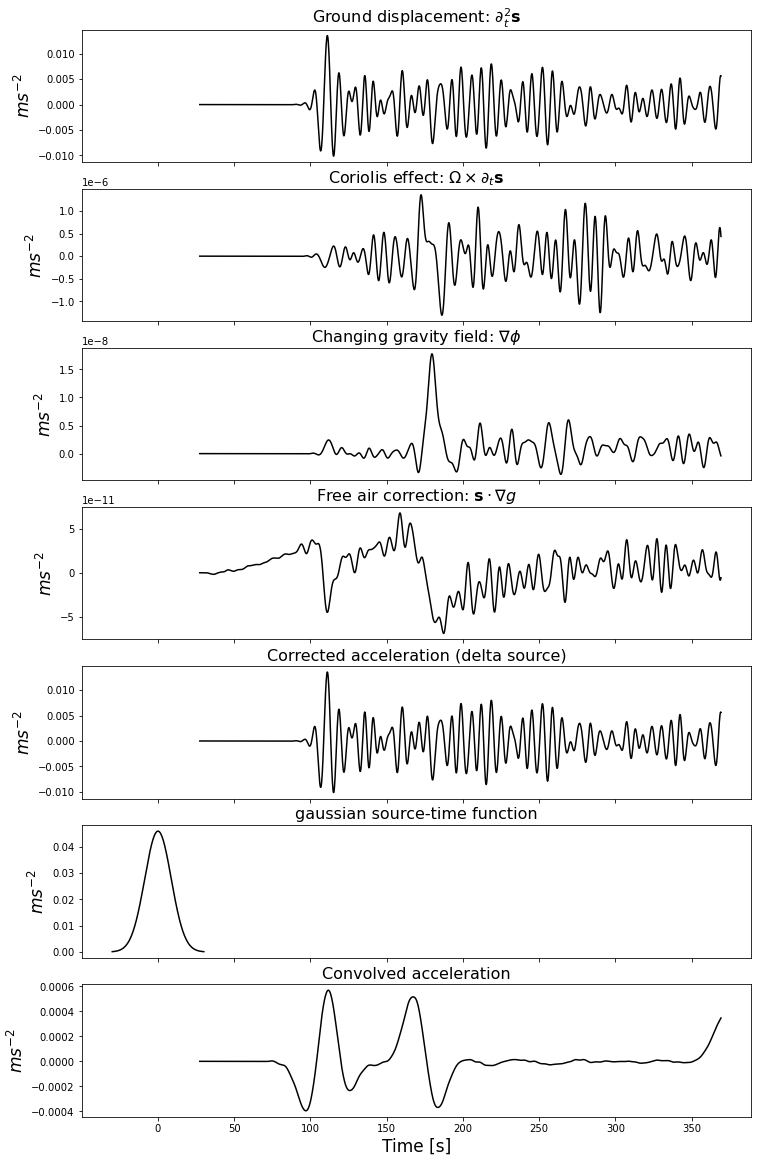

In [6]:
# Plot current stuff: 
fig, ax = plt.subplots(7, figsize=(12,20), sharex=True)

ax[0].plot(sacc_t, synacc[:,1], 'k')
ax[1].plot(sacc_t, corio[:,1], 'k')
ax[2].plot(sacc_t, GRAV[:,1] , 'k')
ax[3].plot(sacc_t, PGRAV[:,1], 'k')

ax[-3].plot(sacc_t, sumarr, 'k')
ax[-2].plot(stf_t, stf, 'k')
ax[-1].plot(acc_t, acc, 'k')

titles = [r'Ground displacement: $\partial_t^2 \mathbf{s}$', 
          r'Coriolis effect: $ \Omega \times \partial_t \mathbf{s} $', 
          r'Changing gravity field: $\nabla \phi $', 
          r'Free air correction: $\mathbf{s}\cdot \nabla g$',
           'Corrected acceleration (delta source)',
          f'{STF} source-time function', 'Convolved acceleration']

for i in range(7):
    ax[i].set_title(titles[i], fontsize=16);
    ax[i].set_ylabel(r'$ms^{-2}$', fontsize=17);

ax[-1].set_xlabel('Time [s]', fontsize=17);


## Write convolved synthetic data to SAC

In [7]:
# Need to pad the trace first with zeros for an hour prior to the arrival:
nindx_1hr = int(3600/sacc_DT)
padded_acc = np.zeros(len(acc) + nindx_1hr)
padded_acc[nindx_1hr:] = acc

tr_for_sac = Trace()
tr_for_sac.data = padded_acc  
tr_for_sac.stats.delta     = sacc_DT
tr_for_sac.stats.starttime = event_time - 3600 + CMT_offset_time
tr_for_sac.stats.channel   = 'SYN_AZ'
tr_for_sac.stats.station   = station
tr_for_sac.stats.network   = networks[station]

# Write to sac: 
tr_for_sac.write(synsac_fname, format='SAC') 

## Create SAC macro for synthetic
This macro runs the relavent commands to process the data in the same way that is done in Vallee et al 2017/Vallee and Juhel 2019

In [8]:
create_bolivia_station_macro(macro_fname = macro_fname,
                             input_fname = macro_inp_fname, 
                             tmp_fname   = macro_tmp_fname, 
                             out_fname   = macro_out_fname, 
                             station=station, 
                             T0=T0[station])

USING 2 poles
Created  ./data/synthetics/PREM/gaussianSAC/LPAZ_macro


## Comparing our synthetics with observed data: 


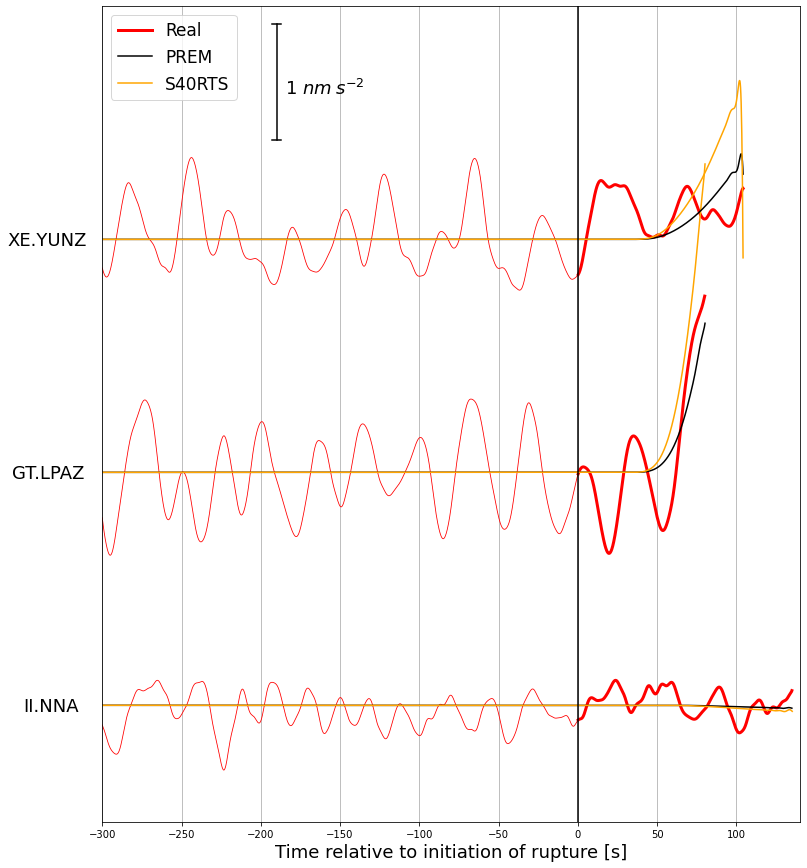

In [9]:
fig_real, ax_real = plt.subplots(figsize=(12.5, 15))
cutamp = 2

# Plot real data: 
for i in range(len(stations)):
    tr_real  = st_real.select(station=stations[i])[0]
    tre, yre = obspy_gen_mpl(tr_real, starttime=-secs_before)

    # fix YUNZ amplitude to nm 
    if stations[i] == 'YUNZ':
        fac = 1e9
        yadd = 0.15
    else: 
        fac  = 1 
        yadd = 0.
    
    # Plot before and after event time separately: 
    ax_real.plot(tre[tre<0], fac*yre[tre<0] + i*cutamp + yadd, 'r', linewidth=0.8)
    real_line, = ax_real.plot(tre[tre>0], fac*yre[tre>0] + i*cutamp + yadd, 'r', linewidth=3)

# Collect line objects for legend
leg_lines = [real_line]



# Load and plot synthetic data: 
for i in range(len(stations)):
    stn = stations[i]
    processed_data_name = f"{stn}_SYN_proc.sac"
    
    # Load data for S40RTS: 
    for STF in STF_list:
        for model in model_list:

            syntr = read(f"{syn_dir}/{model}/{STF}SAC/processed/{processed_data_name}")
            syntr = syntr.slice(starttime=event_time - secs_before, endtime = event_time + secs_after)[0]

            SYNx, SYNy = obspy_gen_mpl(syntr, starttime=-secs_before)
            syn_line, = ax_real.plot(SYNx , 
                                     i*cutamp  + SYNy*1e8, 
                                     color     = model_plot_clrs[model],
                                     linestyle = stf_plot_linestyle[STF])
            leg_lines.append(syn_line)

        
        
# ========================== Bells and whistles: ==========================
ax_real.axvline(0, linestyle='-', color='k')
ax_real.grid
ax_real.set_ylim([-1, 6])
ax_real.set_xlabel('Time relative to initiation of rupture [s]', fontsize=18)
ax_real.text(-360, 4-0.05, 'XE.YUNZ', fontsize=18) # label channel 
ax_real.text(-357, 2-0.05, 'GT.LPAZ', fontsize=18) # label channel 
ax_real.text(-350, 0-0.05, 'II.NNA' , fontsize=18) # label channel 
ax_real.legend(leg_lines, [f'Real', f'PREM', f'S40RTS'], loc='upper left', fontsize=17)        
ax_real.set_yticks([]) 

ax_real.set_xlim([-300, 140])
ax_real.xaxis.grid(True)
    
# --------------- Create scale on figure: ---------------
ymin = 4.85
ymax = 5.85 
val = 3
centre = -190
xmin = (centre - val + 300)/440
xmax = (centre + val + 300)/440

ax_real.axvline(centre, ymin=(ymin+1)/7 , ymax=(ymax+1)/7 , color="k");    
ax_real.axhline(ymin,   xmin=xmin, xmax=xmax, color="k");    
ax_real.axhline(ymax,   xmin=xmin, xmax=xmax, color="k");  
ax_real.text(-185, 5.25, r'1 $nm\:s^{-2}$', fontsize=18);
 # --------------/ Create scale on figure: /--------------

**Note that in the figure above the solid lines = Gaussian STF, dashed line = SCARDEC STF, dotted line = Boxcar STF** (though I may not be plotting them here if I turned off those plots)